In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

C:\Users\polej\AppData\Local\Temp\ipykernel_10528\3785691940.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [15]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path


class LeukocytesDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data", batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 5

        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        # download
        pass

    def setup(self, stage=None):
        train_transforms = self.transform
        val_transforms = self.transform

        # path to data, use pathlib module for cross-platform compatibility

        path_to_dataset = Path(self.data_dir)

        self.train_dataset = ImageFolder(path_to_dataset / "train", train_transforms)
        self.val_dataset = ImageFolder(path_to_dataset / "valid", val_transforms)
        self.test_dataset = ImageFolder(path_to_dataset / "test", val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

In [16]:
DATASET_DIRECTORY = "RAABIN-WBC---KLASYFIKACJA-2"

leukocytes_data_module = LeukocytesDataModule(data_dir=DATASET_DIRECTORY, batch_size=32)
leukocytes_data_module.setup()

In [17]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [20]:
# get dataloader and apply transforms for img_to_patch

leukocytes_data_module = LeukocytesDataModule(data_dir=DATASET_DIRECTORY, batch_size=128)
leukocytes_data_module.setup()

train_loader = leukocytes_data_module.train_dataloader()
val_loader = leukocytes_data_module.val_dataloader()
test_loader = leukocytes_data_module.test_dataloader()


# convert images to tensors of shape [B, C, H, W]

train_data = next(iter(train_loader))
val_data = next(iter(val_loader))
test_data = next(iter(test_loader))

train_images, train_labels = train_data
val_images, val_labels = val_data
test_images, test_labels = test_data

In [19]:
print(f"Size of training set: {train_images.shape}")
print(f"Size of validation set: {val_images.shape}")
print(f"Size of test set: {test_images.shape}")

Size of training set: torch.Size([32, 3, 32, 32])
Size of validation set: torch.Size([32, 3, 32, 32])
Size of test set: torch.Size([32, 3, 32, 32])


In [26]:
NUM_IMAGES = 4

leukocytes_images = torch.stack([val_data[0][i] for i in range(NUM_IMAGES)])
leukocytes_images.shape

torch.Size([4, 3, 32, 32])

In [50]:
img_patches = img_to_patch(leukocytes_images, patch_size=4, flatten_channels=False)

print(f"Size of image patches: {img_patches.shape}")

Size of image patches: torch.Size([4, 64, 3, 4, 4])


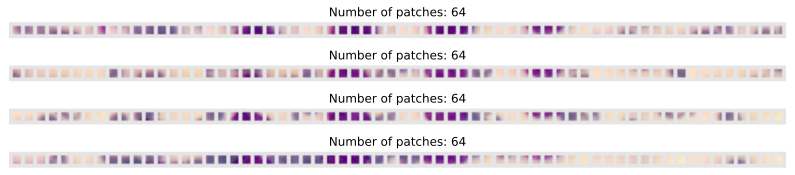

In [52]:
# plot image patches

fig, ax = plt.subplots(leukocytes_images.shape[0], 1, figsize=(14,3))
for i in range(leukocytes_images.shape[0]):
    # plot number of patches per image
    ax[i].set_title(f"Number of patches: {img_patches[i].shape[0]}")
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()

In [53]:
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [54]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [55]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [56]:
CHECKPOINT_PATH = "../checkpoints"

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [57]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=5,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])


    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return trainer, model, result

In [58]:
trainer, model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 5,
                                'dropout': 0.2
                            },
                            lr=3e-4)
print("ViT results", results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ..\checkpoints\ViT\lightning_logs

  | Name  | Type              | Params | In sizes         | Out sizes
---------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [128, 3, 32, 32] | [128, 5] 
---------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.775    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\polej\.conda\envs\lcbsi\lib\site-packages\pytorch_lightning\trainer\trainer.py:1558: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]